In [148]:
import numpy as np
import cv2
from imutils.object_detection import non_max_suppression
import pytesseract
from matplotlib import pyplot as plt

In [149]:
args = {"image":" Free-Outdoor-Advertisment-Direction-Signage-Mockup-PSD-File.jpg", "east":"frozen_east_text_detection.pb", "min_confidence":0.5, "width":320, "height":320}

In [150]:
args['image']='Free-Outdoor-Advertisment-Direction-Signage-Mockup-PSD-File.jpg'
image = cv2.imread(args['image'])

#Saving an original image and shape
orig = image.copy()
(origH, origW) = image.shape[:2]

# set the new height and width  
(newW, newH) = (args["width"], args["height"])

#Calculate the ratio between original and new image for both height and weight. 
#This ratio will be used to translate bounding box location on the original image. 
rW = origW / float(newW)
rH = origH / float(newH)

# resize the original image to new dimensions
image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]

# construct a blob from the image to forward pass it to EAST model
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
	(123.68, 116.78, 103.94), swapRB=True, crop=False)

In [151]:
# load the pre-trained EAST model for text detection 
net = cv2.dnn.readNet(args["east"])

# We would like to get two outputs from the EAST model. 
#1. Probabilty scores for the region whether that contains text or not. 
#2. Geometry of the text -- Coordinates of the bounding box detecting a text

layerNames = ["feature_fusion/Conv_7/Sigmoid","feature_fusion/concat_3"]

In [152]:
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)

In [153]:
def predictions(prob_score, geo):
    (numR, numC) = prob_score.shape[2:4]
    boxes = []
    confidence_val = []
    
    # loop over rows
    for y in range(0, numR):
        scoresData = prob_score[0, 0, y]
        x0 = geo[0, 0, y]
        x1 = geo[0, 1, y]
        x2 = geo[0, 2, y]
        x3 = geo[0, 3, y]
        anglesData = geo[0, 4, y]
        
        # loop over the number of columns
        for i in range(0, numC):
            if scoresData[i] < args["min_confidence"]:
                continue
                
            (offX, offY) = (i * 4.0, y * 4.0)
            
            # extracting the rotation angle for the prediction and computing the sine and cosine
            angle = anglesData[i]
            cos = np.cos(angle)
            sin = np.sin(angle)
            
            # using the geo volume to get the dimensions of the bounding box
            h = x0[i] + x2[i]
            w = x1[i] + x3[i]
            
            # compute start and end for the text pred bbox
            endX = int(offX + (cos * x1[i]) + (sin * x2[i]))
            endY = int(offY - (sin * x1[i]) + (cos * x2[i]))
            startX = int(endX - w)
            startY = int(endY - h)
            
            boxes.append((startX, startY, endX, endY))
            confidence_val.append(scoresData[i])
            
    # return bounding boxes and associated confidence_val
    return (boxes, confidence_val)

In [154]:
# Find predictions and  apply non-maxima suppression
(boxes, confidence_val) = predictions(scores, geometry)
boxes = non_max_suppression(np.array(boxes), probs=confidence_val)

In [155]:
#Text Detection and Recognition 

# initialize the list of results
results = []

# loop over the bounding boxes to find the coordinate of bounding boxes
for (startX, startY, endX, endY) in boxes:
    # scale the coordinates based on the respective ratios in order to reflect bounding box on the original image
    startX = int(startX * rW)
    startY = int(startY * rH)
    endX = int(endX * rW)
    endY = int(endY * rH)
    
    #extract the region of interest
    r = orig[startY:endY, startX:endX]
    
    #configuration setting to convert image to string.  
    configuration = ("-l eng --oem 1 --psm 8")
    #This will recognize the text from the image of bounding box
    text = pytesseract.image_to_string(r, config=configuration)
    
    # append bbox coordinate and associated text to the list of results 
    results.append(((startX, startY, endX, endY), text))

MARKETING CO
a -50-)"
HERE
ARE
Biciaestyic hele
NE


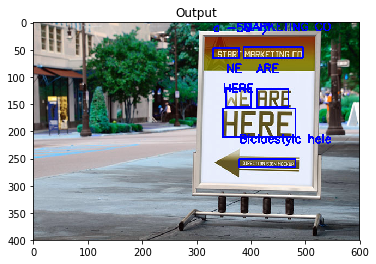

In [156]:
orig_image = orig.copy()

# Moving over the results and display on the image
for ((start_X, start_Y, end_X, end_Y), text) in results:
    # display the text detected by Tesseract
    print("\n".format(text))
    
    # Displaying text
    text = "".join([x if ord(x) < 128 else "" for x in text]).strip()
    cv2.rectangle(orig_image, (start_X, start_Y), (end_X, end_Y),(0, 0, 255), 2)
    cv2.putText(orig_image, text, (start_X, start_Y - 30),cv2.FONT_HERSHEY_SIMPLEX, 0.7,(0,0, 255), 2)

plt.imshow(orig_image)
plt.title('Output')
plt.show()